## Importation des données

In [1]:
import pandas
import numpy as np

D:\Programmes\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')

In [9]:
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [10]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.13)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time

In [21]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 200)
        self.fc2 = nn.Linear(200,1)
#        self.fc3 = nn.Linear(100, 1)
#        self.fc4 = nn.Linear(50, 20)
#        self.fc5 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
#        x = self.fc3(x)
#         x = self.fc4(x)
#         x = self.fc5(x)
        return x

In [13]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [22]:
def train(data, labels, nepochs):
    
    trainset = hockey_dataset(
        data[:train_size], labels[:train_size])
    validset = hockey_dataset(
        data[train_size:train_size+valid_size], labels[train_size:train_size+valid_size])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=100, shuffle = False)
    
    network = Network().to(device)
    criterion = nn.MSELoss()
    lr = 0.0000001
    optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.1, momentum = 0)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        if (epoch > 0) and (epoch%100 == 0):
            lr = lr*0.75
            optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
        current_loss_train, current_loss_valid = 0,0
        network.train()
        for data in trainloader:
            inputs, label = data
            optimizer.zero_grad()
            output = network(inputs.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            current_loss_train += loss.item()/train_size
        loss_train.append(current_loss_train)
        
        with torch.no_grad():
            network.eval()
            for data in validloader:
                inputs, label = data
                output = network(inputs.to(device))
                loss = criterion(output, label.to(device))
                current_loss_valid += loss.item()/valid_size
        loss_valid.append(current_loss_valid)
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train loss: {0:.4f}'.format(loss_train[-1]))
            print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Finished Training')
    
    print('Mean loss of last 50 iterations(test): ',np.array(loss_train[-50:]).mean())
    print('Mean loss of last 50 iterations(valid): ',np.array(loss_valid[-50:]).mean())

#     with torch.no_grad():
#         for data in validloader:
#             inputs
    
    return loss_train, loss_valid

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

Epoch: 0
Train loss: 1.5348
Valid loss: 3.1975
Epoch: 100
Train loss: 0.4758
Valid loss: 0.7202
Epoch: 200
Train loss: 0.3382
Valid loss: 0.5217
Epoch: 300
Train loss: 0.3052
Valid loss: 0.5550
Epoch: 400
Train loss: 0.2508
Valid loss: 0.3864
Epoch: 500
Train loss: 0.2491
Valid loss: 0.3557
Epoch: 600
Train loss: 0.2576
Valid loss: 0.3762
Epoch: 700
Train loss: 0.2326
Valid loss: 0.3235
Epoch: 800
Train loss: 0.2377
Valid loss: 0.3455
Finished Training
Mean loss of last 50 iterations(test):  0.22714324413869008
Mean loss of last 50 iterations(valid):  0.32782191749241035
Temps d'entrainement : 24.44330596923828


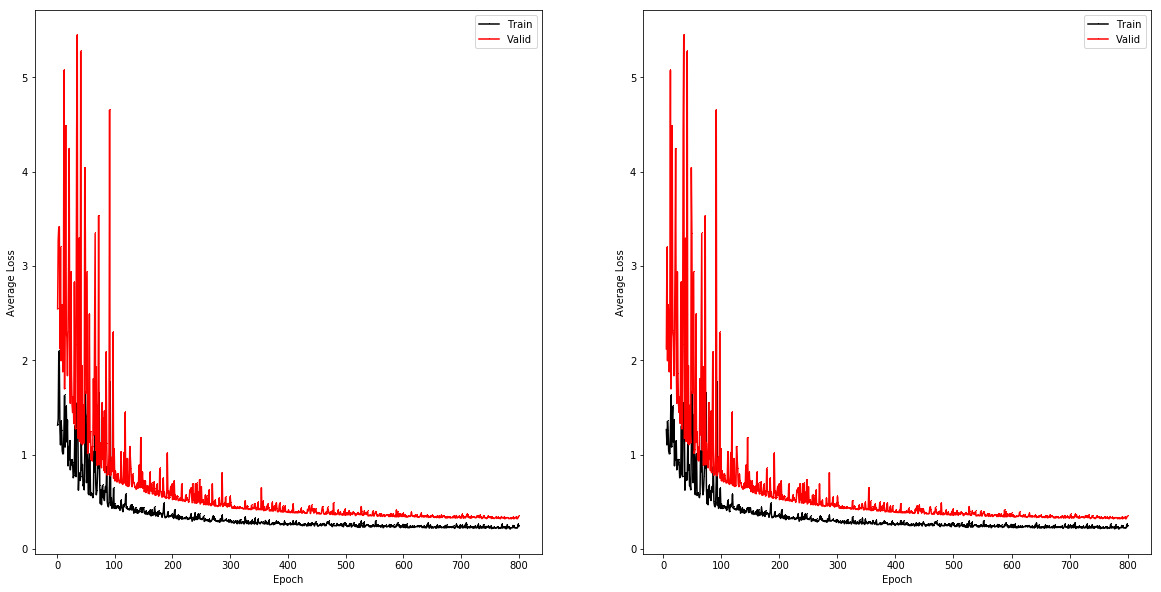

In [23]:
nepochs = 801
t1 = time.time()
loss_train, loss_valid = train(data, targets_goals, nepochs)
print("Temps d'entrainement : {}".format(time.time()-t1))
torch.cuda.empty_cache()

fig,ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
ax1, ax2 = ax.flatten()
ax1.plot(range(1,nepochs), loss_train[1:], 'k,-', label='Train')
ax1.plot(range(1,nepochs), loss_valid[1:], 'r,-', label='Valid')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

ax2.plot(range(5,nepochs), loss_train[5:], 'k,-', label='Train')
ax2.plot(range(5,nepochs), loss_valid[5:], 'r,-', label='Valid')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Loss')
ax2.legend()
plt.show()

In [17]:
# network = Network().to(device)

# checkpoint = torch.load('state_dict')
# network.load_state_dict(checkpoint)

In [18]:
# validset = hockey_dataset(
#         data[train_size:train_size+valid_size], targets_goals[train_size:train_size+valid_size])
# validloader = torch.utils.data.DataLoader(validset, batch_size=100, shuffle = False)

# network.eval()
# loss_list = []
# # with torch.no_grad():
# #     for data in validloader:
# #         inputs, label = data
# #         output = network(inputs.to(device))
# #         loss = criterion(output, label.to(device))
# #         loss_list.append(loss)
# with torch.no_grad():
#     for data in validloader:
#         inputs, label = data
#         output = network(inputs.to(device))
#         loss = criterion(output, label.to(device))
#         current_loss_valid += loss.item()/valid_size
# print(loss)